In [1]:
pip install --upgrade pyspark

Defaulting to user installation because normal site-packages is not writeable
  Using cached pyspark-3.5.1-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pyspark
print(pyspark.__version__)

3.5.0


In [4]:
import os
import warnings as w
w.filterwarnings('ignore')
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, expr

In [5]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("FacebookAddataAnalysis") \
    .getOrCreate()

# Load the dataset from HDFS
file_path = "/data/ProjectDatasetFacebookAU/*"  # Updated file path with wildcard *
data = spark.read.format("json").load(file_path)

24/05/20 04:49:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
data.printSchema()

root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_bodies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_captions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_descriptions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_creative_link_titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- bylines: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- delivery_by_region: array (nullable = true)
 |    |-- element: struct (containsN

In [7]:
data_cleaned = data.na.fill({"ad_creative_body": "","ad_creative_link_caption": "",
                        "ad_creative_link_title": "","ad_creative_link_description": "",
                        "funding_entity": "","page_name": "", "ad_delivery_stop_time": "2028-01-31" })

In [9]:
data_cleaned.show(10)

+----------------+------------------+--------------------+------------------------+-------------------------+----------------------------+-----------------------------+----------------------+-----------------------+----------------------+---------------------+--------------------+-------+--------+------------------+------------------------+-----------------------+--------------------+----------------+------------+---------+----------------+--------------------+-------------------+--------------------+----------+
|ad_creation_time|ad_creative_bodies|    ad_creative_body|ad_creative_link_caption|ad_creative_link_captions|ad_creative_link_description|ad_creative_link_descriptions|ad_creative_link_title|ad_creative_link_titles|ad_delivery_start_time|ad_delivery_stop_time|     ad_snapshot_url|bylines|currency|delivery_by_region|demographic_distribution|estimated_audience_size|      funding_entity|              id| impressions|languages|         page_id|           page_name|publisher_platfor

In [10]:
from pyspark.sql import SparkSession, SQLContext 
from pyspark.sql.types import * 
from pyspark.sql.functions import avg, array_contains, to_date, mean, min, max, lit, col, first, last, sum, count, countDistinct, desc, explode, split
pyspark.sql.DataFrameNaFunctions 

pyspark.sql.dataframe.DataFrameNaFunctions

In [11]:
data_cleaned_4=data_cleaned.dropDuplicates() 

In [12]:
data_cleaned_4 = data_cleaned_4.filter((col("ad_creative_body") != "Unknown") | (col("ad_creative_link_caption") != "Unknown")| (col("ad_creative_link_description") != "Unknown") | (col("ad_creative_link_title") != "Unknown")) 

In [13]:
data_cleaned_4=data_cleaned_4.withColumn('year', split(data['ad_creation_time'], '-').getItem(0)
                                        ).withColumn('month', split(data['ad_creation_time'], '-').getItem(1)
                                        ).withColumn('day', split(data['ad_creation_time'], '-').getItem(2)
                                        ).withColumn("spend_lower_bound", col("spend.lower_bound").cast("double")
                                        ).withColumn("spend_upper_bound", col("spend.upper_bound").cast("double")
                                        ).withColumn("impressions_lower_bound", col("impressions.lower_bound").cast("double")
                                        ).withColumn("impressions_upper_bound", col("impressions.upper_bound").cast("double")
                                        ).withColumn("ad_delivery_start_time", col("ad_delivery_start_time").cast("timestamp")
                                        ).withColumn("ad_delivery_stop_time", col("ad_delivery_stop_time").cast("timestamp")
                                        ).withColumn("demographic_distribution", col("demographic_distribution").cast("array<struct<age: string, gender: string, percentage: double>>")
                                        ).withColumn("region_distribution", col("region_distribution").cast("array<struct<percentage: double, region: string>>")
                                        ).withColumn("year", col("year").cast("integer")
                                        ).withColumn("month", col("month").cast("integer")
                                        ).withColumn("day", col("day").cast("integer")
                                        ).withColumn("ad_creation_time", col("ad_creation_time").cast("timestamp")) 

In [14]:
data_cleaned_4.show(10)

+-------------------+--------------------+----------------+------------------------+-------------------------+----------------------------+-----------------------------+----------------------+-----------------------+----------------------+---------------------+--------------------+-------+--------+------------------+------------------------+-----------------------+--------------+----------------+-----------+---------+----------------+--------------------+--------------------+-------------------+-----+----+-----+---+-----------------+-----------------+-----------------------+-----------------------+
|   ad_creation_time|  ad_creative_bodies|ad_creative_body|ad_creative_link_caption|ad_creative_link_captions|ad_creative_link_description|ad_creative_link_descriptions|ad_creative_link_title|ad_creative_link_titles|ad_delivery_start_time|ad_delivery_stop_time|     ad_snapshot_url|bylines|currency|delivery_by_region|demographic_distribution|estimated_audience_size|funding_entity|            

In [21]:
# Count the non-null values in the "ad_creation_time" column
count_ad_creation_caption = data_cleaned_4.select("ad_creative_link_caption").count()
print("Count of values in 'ad_creation_time' column:", count_ad_creation_caption)

Count of values in 'ad_creation_time' column: 20694375


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words and len(word) > 2]
    preprocessed_text = " ".join(filtered_words)
    
    return preprocessed_text

[nltk_data] Downloading package punkt to /home/s4771984/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/s4771984/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from pyspark.sql.functions import col
from wordcloud import WordCloud
import matplotlib.pyplot as plt

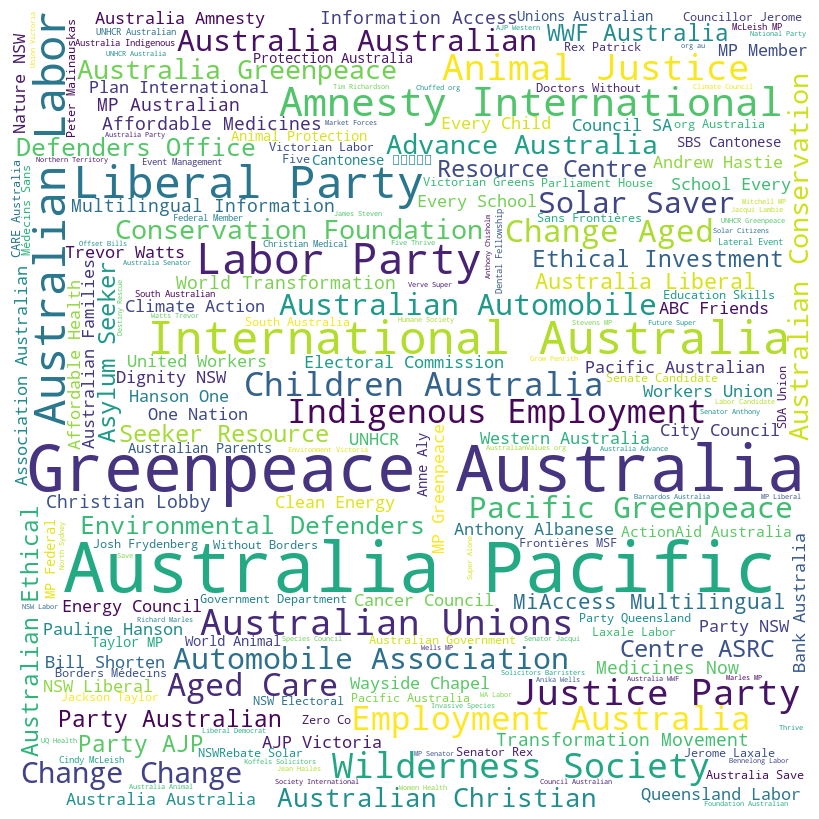

In [22]:
text_column = "page_name"

# Extract the text data from the DataFrame
text_data = data_cleaned_4.select(text_column).rdd.map(lambda row: row[0]).filter(lambda x: x is not None)
text_combined = " ".join(text_data.collect())

wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_combined)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Show the word cloud visualization
plt.show()

In [14]:
text_column = "ad_creative_link_caption"

# Extract the text data from the DataFrame
text_data = data_cleaned_4.select(text_column).rdd.map(lambda row: row[0]).filter(lambda x: x is not None)

# Preprocess the text data (remove stopwords, filter noisy words, etc.)
# You can use libraries like NLTK or SpaCy for this step

# Concatenate all the text data into a single string
text_combined = " ".join(text_data.collect())

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_combined)

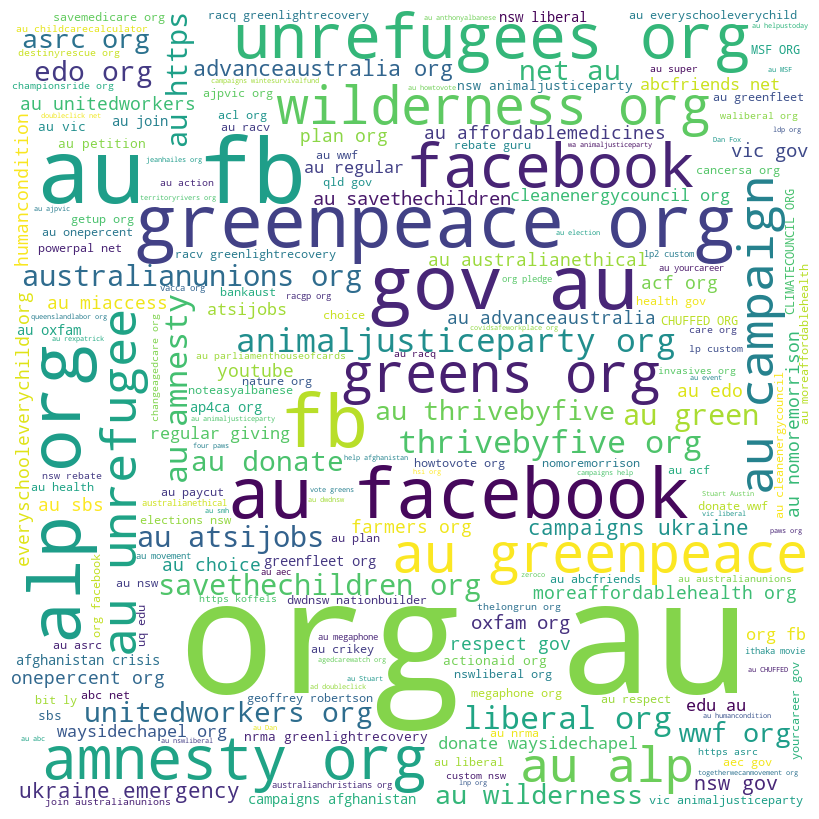

In [15]:
# Display the word cloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Show the word cloud visualization
plt.show()

In [16]:
text_column = "ad_creative_link_description"

# Extract the text data from the DataFrame
text_data = data_cleaned_4.select(text_column).rdd.map(lambda row: row[0]).filter(lambda x: x is not None)

# Preprocess the text data (remove stopwords, filter noisy words, etc.)
# You can use libraries like NLTK or SpaCy for this step

# Concatenate all the text data into a single string
text_combined = " ".join(text_data.collect())

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_combined)

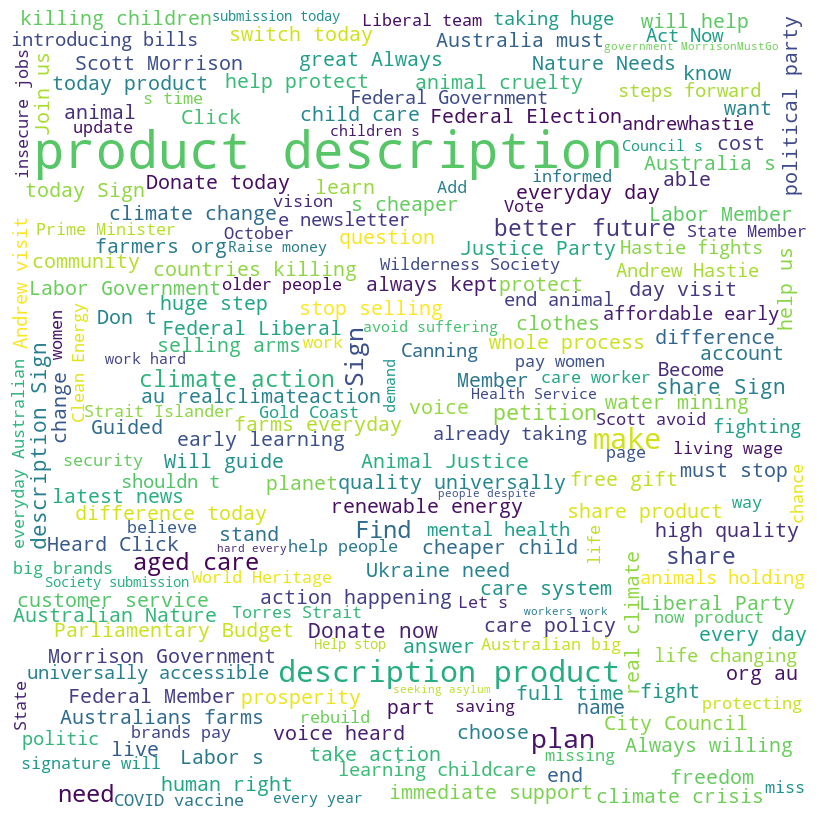

In [17]:
# Display the word cloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Show the word cloud visualization
plt.show()

In [18]:
import re

# Extract hashtags from ad_creative_body
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

hashtag_df = data_cleaned_4.withColumn("hashtags", F.explode(F.udf(extract_hashtags, ArrayType(StringType()))(col("ad_creative_body"))))

hashtag_counts = hashtag_df.groupBy("hashtags").count().orderBy("count", ascending=False)
hashtag_counts_pd = hashtag_counts.toPandas()

24/05/19 07:59:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


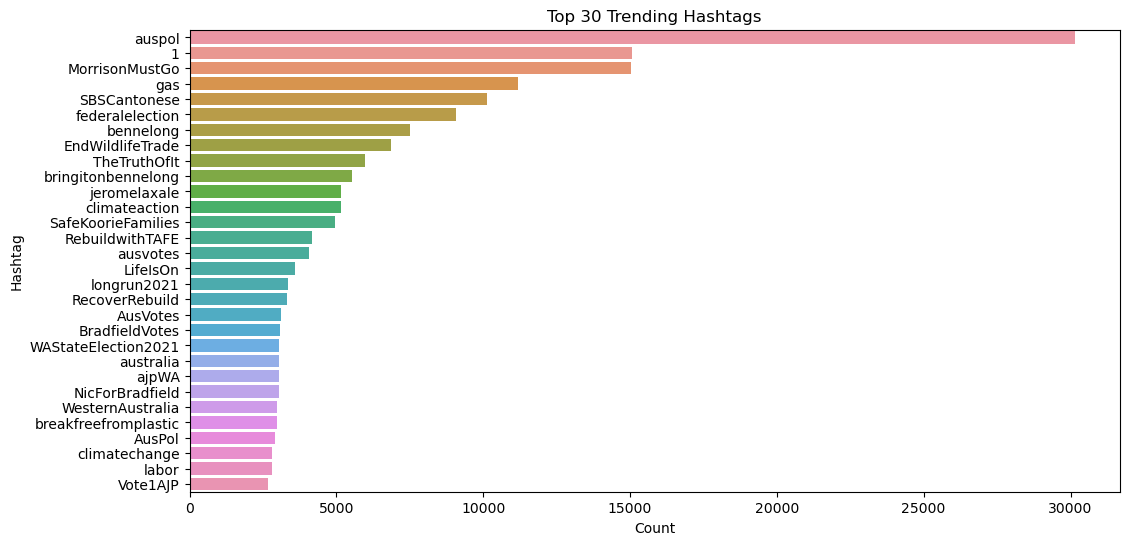

In [19]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=hashtag_counts_pd.head(30), y='hashtags', x='count')
plt.title('Top 30 Trending Hashtags')
plt.ylabel('Hashtag')
plt.xlabel('Count')
plt.show()

In [20]:
spend_over_time = data_cleaned_4.withColumn("ad_creation_date", F.to_date("ad_creation_time"))
spend_over_time = spend_over_time.groupBy("ad_creation_date").agg(F.sum(F.col("spend_lower_bound").cast("float")).alias("total_spend"))

spend_over_time_pd = spend_over_time.toPandas()

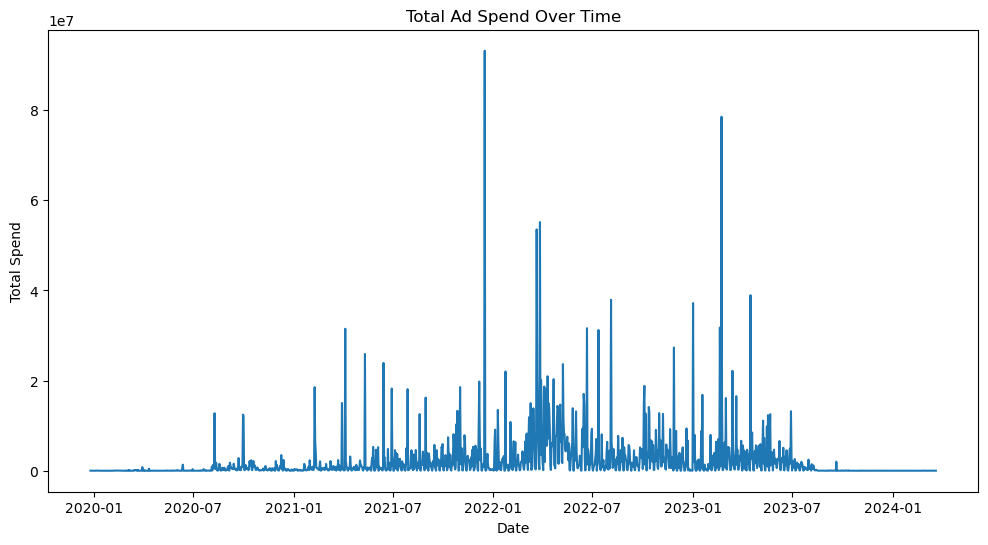

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=spend_over_time_pd, x='ad_creation_date', y='total_spend')
plt.title('Total Ad Spend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.show()

In [22]:
funding_entity_spend = data_cleaned_4.groupBy("funding_entity") \
                         .agg(F.sum(F.col("spend_lower_bound").cast("float")).alias("total_spend")) \
                         .orderBy("total_spend", ascending=False)

funding_entity_spend_pd = funding_entity_spend.toPandas()

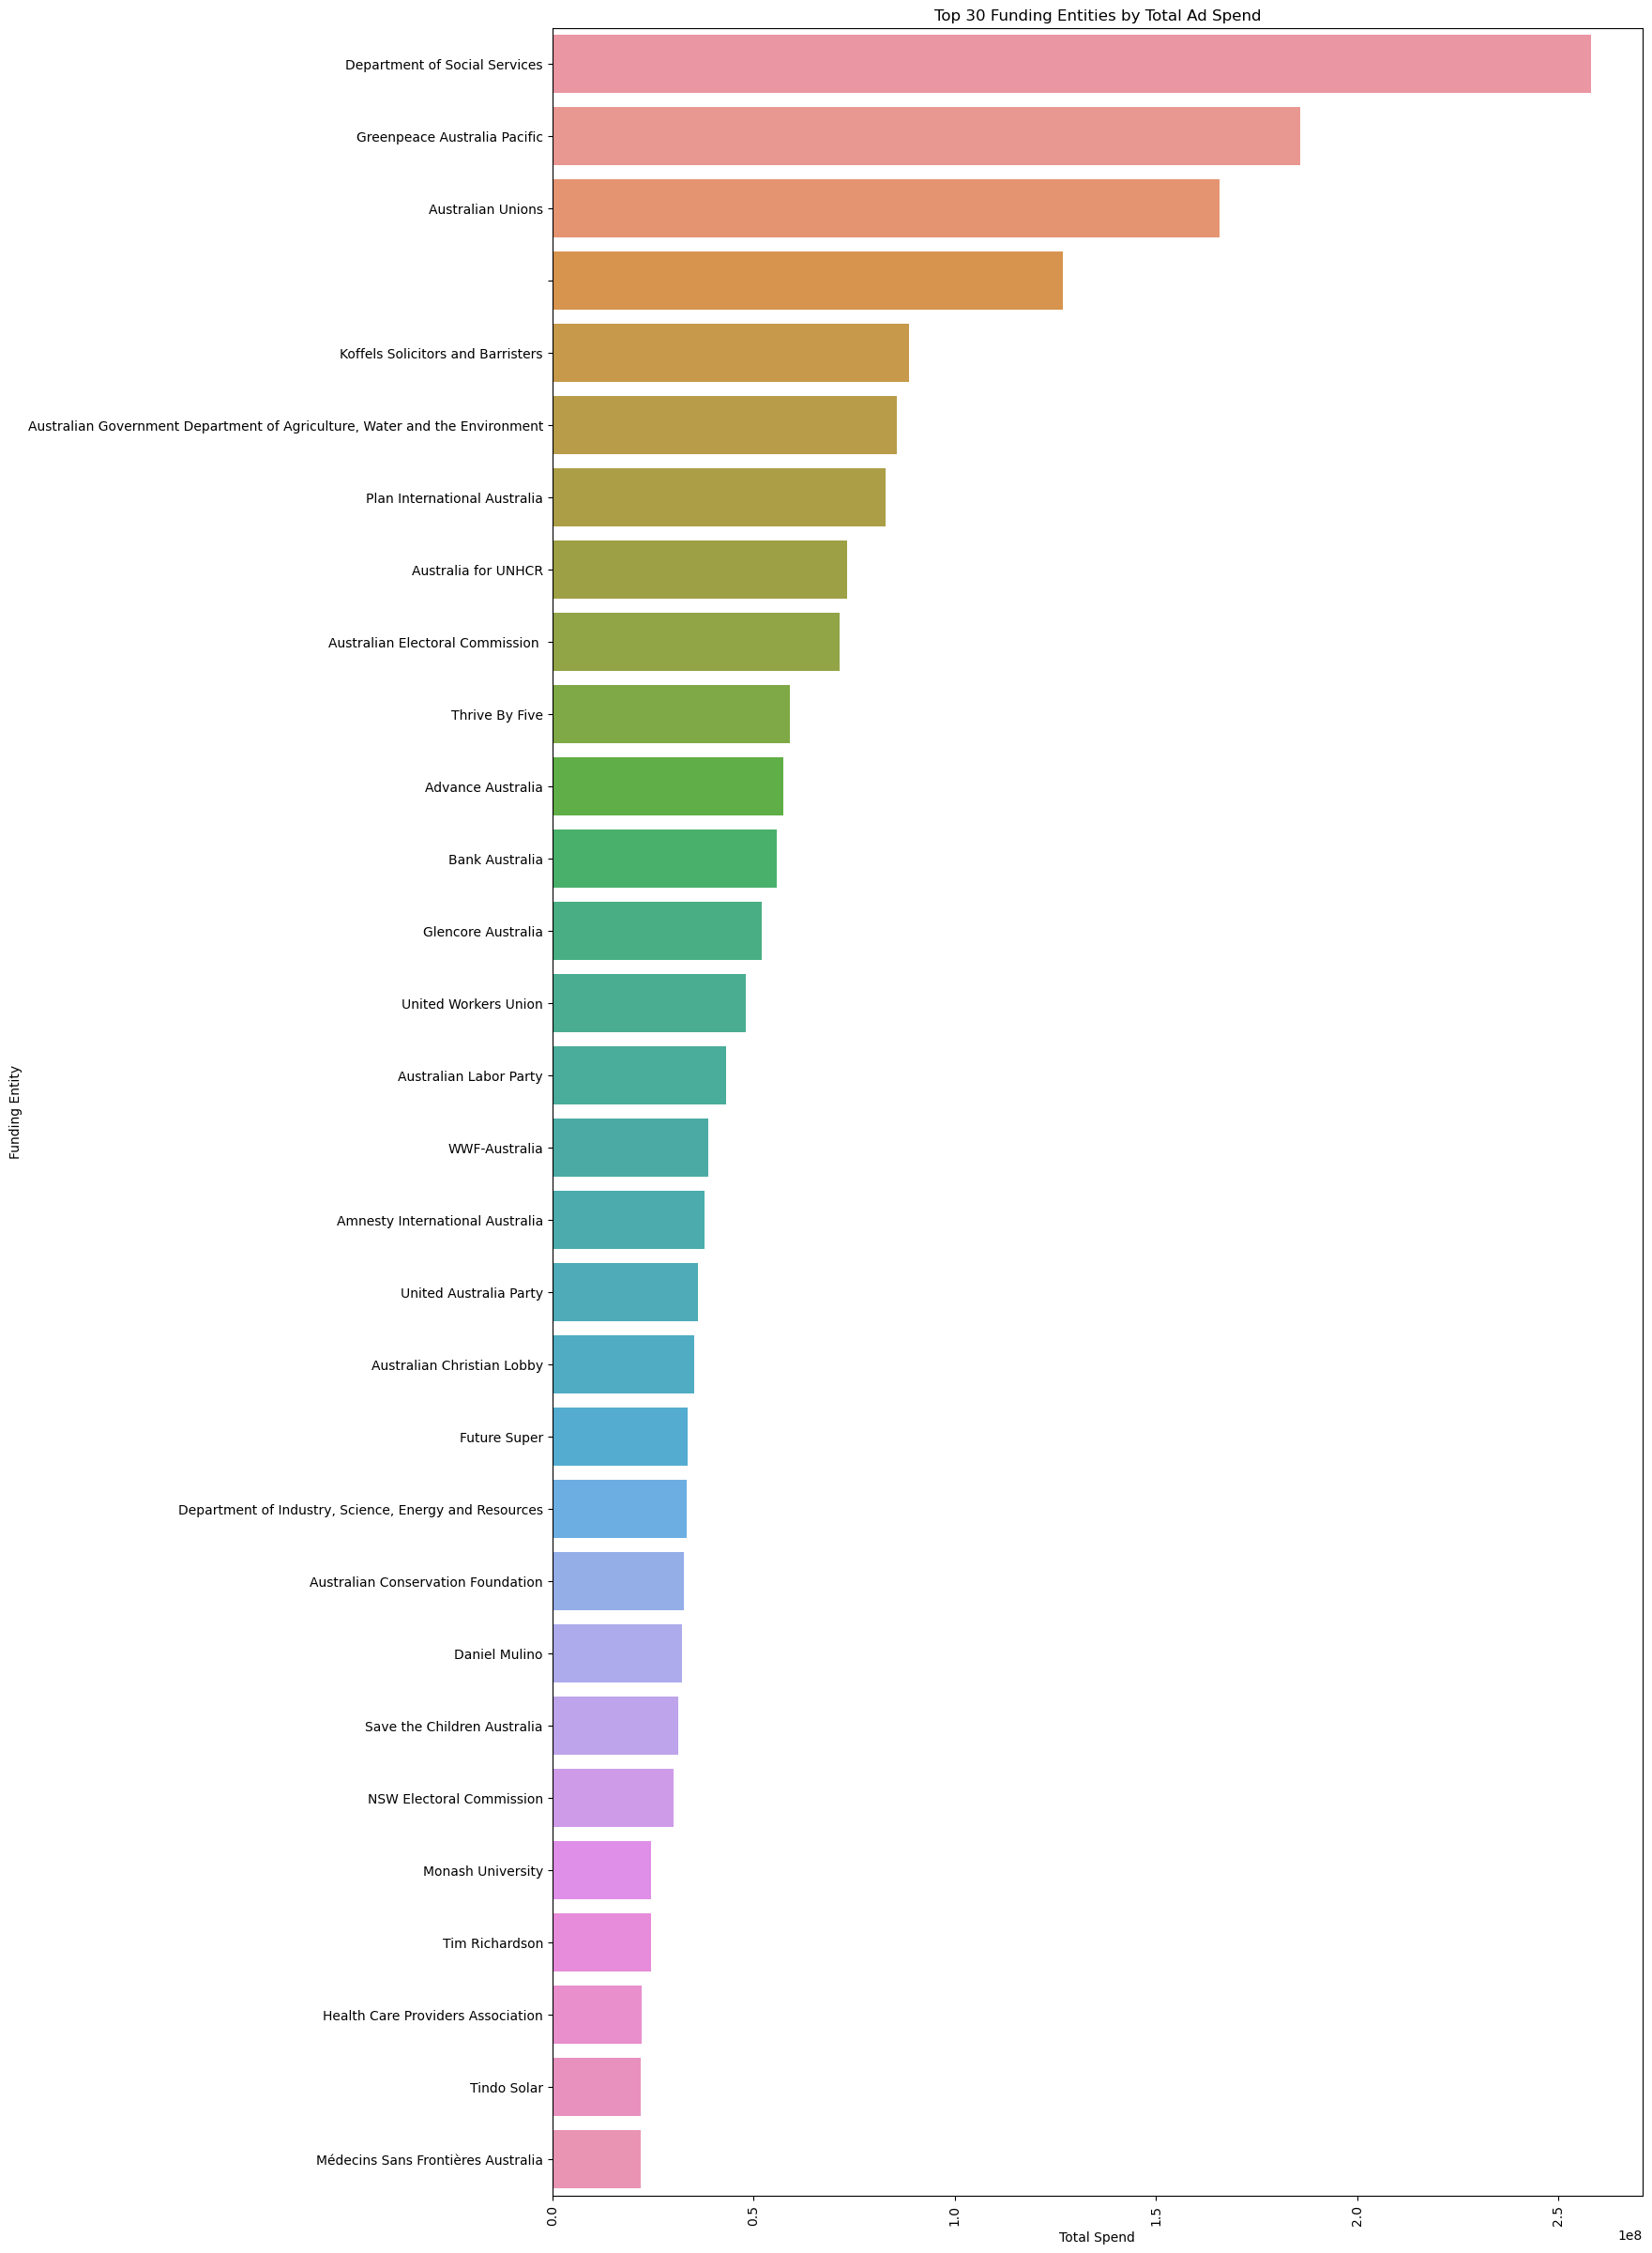

In [23]:
plt.figure(figsize=(15, 30))
sns.barplot(data=funding_entity_spend_pd.head(30), y='funding_entity', x='total_spend')
plt.xticks(rotation=90)
plt.title('Top 30 Funding Entities by Total Ad Spend')
plt.ylabel('Funding Entity')
plt.xlabel('Total Spend')
plt.show()

In [24]:
spend_demographics = data_cleaned_4.withColumn("demographics", explode("demographic_distribution"))

spend_per_demo = spend_demographics.groupBy("demographics.age", "demographics.gender") \
    .agg(F.sum(F.col("spend_lower_bound").cast("float")).alias("spend_lower"),
         F.sum(F.col("spend_upper_bound").cast("float")).alias("spend_upper"))

In [25]:
spend_per_demo_pd = spend_per_demo.toPandas()

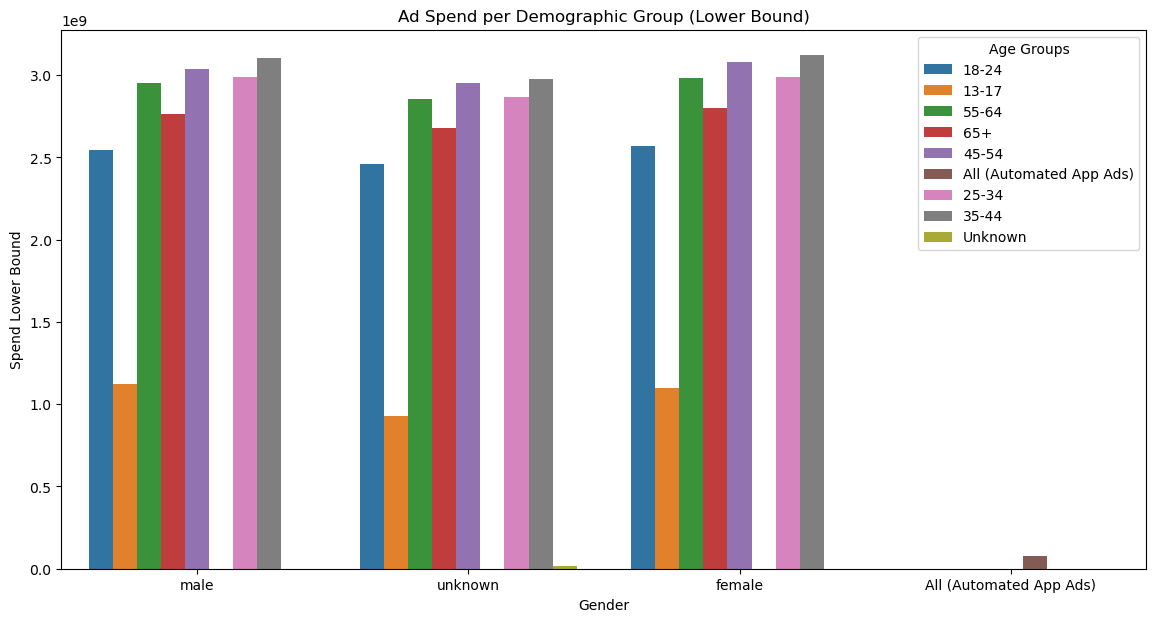

In [26]:
plt.figure(figsize=(14, 7))
sns.barplot(data=spend_per_demo_pd, x='gender', y='spend_lower', hue='age')
plt.title('Ad Spend per Demographic Group (Lower Bound)')
plt.xlabel('Gender')
plt.ylabel('Spend Lower Bound')
plt.legend(title='Age Groups',loc='upper right')
plt.show()

In [27]:
region_distribution_pd = data_cleaned_4.withColumn("region", explode("region_distribution.region")) \
                           .groupBy("region").count().orderBy("count", ascending=False) \
                           .toPandas().head(30)

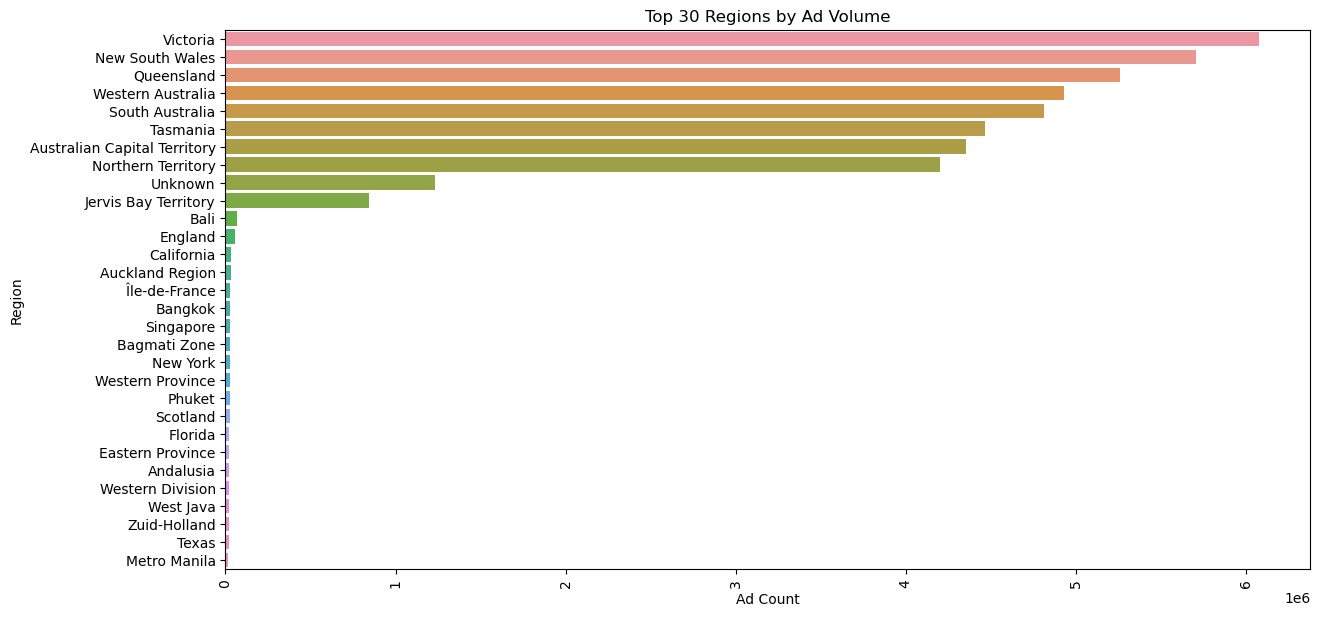

In [28]:
plt.figure(figsize=(14, 7))
sns.barplot(data=region_distribution_pd, y='region', x='count')
plt.title('Top 30 Regions by Ad Volume')
plt.ylabel('Region')
plt.xlabel('Ad Count')
plt.xticks(rotation=90)
plt.show()